In [1]:
from matplotlib.ticker import ScalarFormatter
from posixpath import join
from posixpath import split
from pandas.io.parsers.readers import read_table
from tqdm import tqdm
from scipy.signal import find_peaks
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
font_size = 14
# colors = [
#     '#934B43',  # RGB: 147 75 67
#     '#D76364',  # RGB: 215 99 100
#     '#EF7A6D',  # RGB: 239 122 109
#     '#F1D77E',  # RGB: 241 215 126
#     '#B1CE46',  # RGB: 177 206 70
#     '#63E398',  # RGB: 99 227 152
#     '#9394E7',  # RGB: 147 148 231
#     '#5F97D2',  # RGB: 95 151 210
#     '#9DC3E7'   # RGB: 157 195 231
# ]

colors = [
    '#2E86AB',  # Steel Blue
    '#A23B72',  # Berry
    '#F18F01',  # Orange
    '#C73E1D',  # Coral Red
    '#3B1F2B',  # Dark Purple
    '#44CF6C',  # Emerald
    '#7209B7',  # Royal Purple
    '#4361EE',  # Royal Blue
    '#4CC9F0'   # Cyan
]

formatter = ScalarFormatter(useMathText=True) 
formatter.set_scientific(True) 
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 10,
    'figure.figsize': (4, 3),
    'figure.dpi': 300,
    'lines.linewidth': 3,
    'axes.linewidth': 1.5,
    'ytick.direction': 'in',
    'xtick.direction': 'in',
})

In [2]:


def baseline_als(y, lam, p, niter=100):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# For more info see the paper and https://stackoverflow.com/questions/29156532/python-baseline-correction-library

def baseline_remove(Y_Data,switch_on= False):
  if switch_on:
    l= 2e+7

    p=0.08
    baseline = baseline_als(Y_Data,l,p)
    Correct_data = Y_Data - baseline
  else:
    Correct_data = Y_Data
  
  return Correct_data,baseline

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob

def visualize_channel_data(data_dir):
    """
    Visualize all channel data files in the specified directory.
    
    Args:
        data_dir (str): Directory containing channel data files
    """
    # Find all CSV files that match the channel naming pattern
    channel_files = glob.glob(os.path.join(data_dir, "CH*_*.csv"))
    
    if not channel_files:
        print(f"No channel data files found in {data_dir}")
        return
    
    # Create a figure for plotting
    plt.figure(figsize=(12, 6))
    
    # Process each channel file
    for file_path in channel_files:
        # Extract channel name from filename
        filename = os.path.basename(file_path)
        channel_name = filename.split('_')[0]
        
        try:
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Check if the data has the expected columns
            if 'Time(s)' in df.columns and 'Voltage(V)' in df.columns:
                # Remove duplicate time points (if any)
                df = df.drop_duplicates(subset=['Time(s)'])
                
                # Plot the data
                plt.plot(df['Time(s)'], df['Voltage(V)'], label=channel_name)
            else:
                print(f"Warning: {filename} does not have the expected columns")
                
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    # Add labels and legend
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('Channel Voltage Measurements')
    plt.legend()
    plt.grid(True)
    
    # Save the figure
    output_path = os.path.join(data_dir, "channel_visualization.png")
    plt.savefig(output_path, dpi=300)
    print(f"Visualization saved to {output_path}")
    
    # Show the plot
    plt.show()



Visualization saved to /Volumes/T7_Shield/Papers/nano/data/data/x-/channel_visualization.png


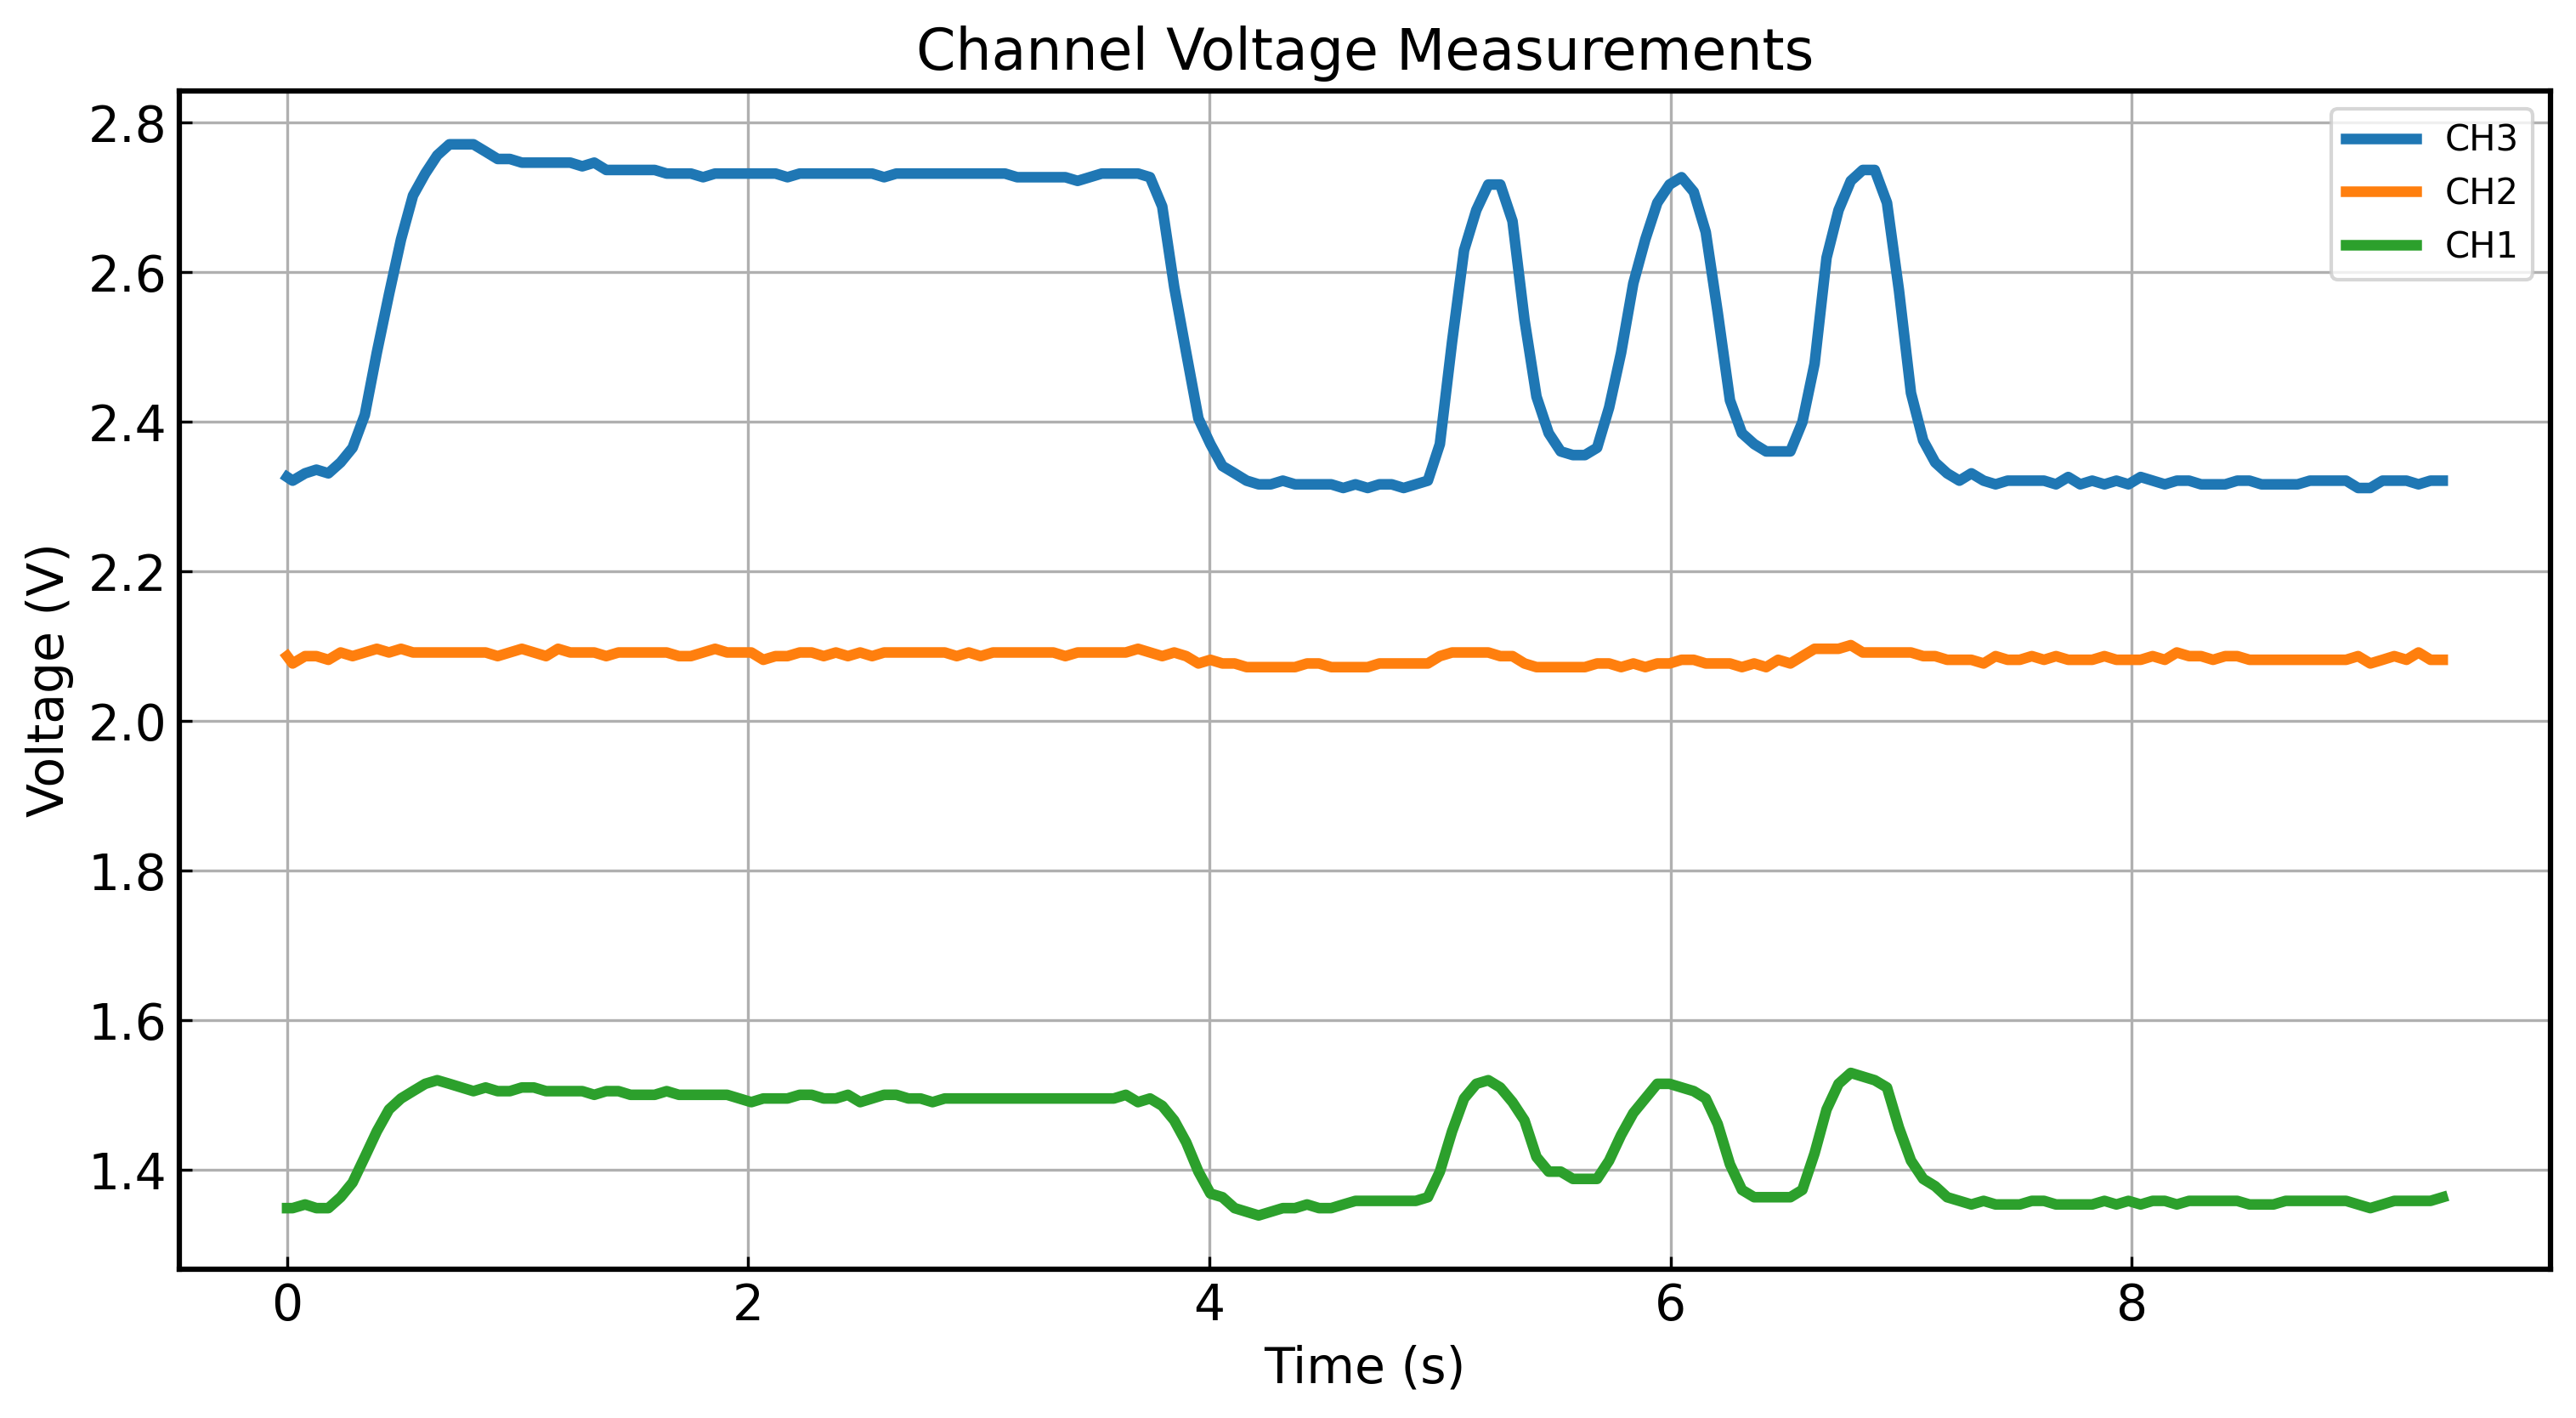

In [4]:
data_dir = "/Volumes/T7_Shield/Papers/nano/data/data/x-"
visualize_channel_data(data_dir)

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob

def visualize_channel_data(data_dir):
    """
    Visualize all channel data files in the specified directory using subplots.
    
    Args:
        data_dir (str): Directory containing channel data files
    """
    # Find all CSV files that match the channel naming pattern
    channel_files = glob.glob(os.path.join(data_dir, "CH*_*.csv"))
    
    if not channel_files:
        print(f"No channel data files found in {data_dir}")
        return
    
    channel_files.sort()
    
    # Create a figure with 1x3 subplots
    fig, axes = plt.subplots(4, 1, figsize=(6,6),sharey=True)
    
    # Process each channel file
    for i, file_path in enumerate(channel_files[:4]):  # Limit to first 3 channels
        # Extract channel name from filename
        filename = os.path.basename(file_path)
        channel_name = filename.split('_')[0]
        
        try:
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Check if the data has the expected columns
            if 'Time(s)' in df.columns and 'Voltage(V)' in df.columns:
                # Remove duplicate time points (if any)
                df = df.drop_duplicates(subset=['Time(s)'])
                df['baseline_removed'],_= baseline_remove(df['Voltage(V)'],True)
                # Plot the data on the appropriate subplot
                ax = axes[i] if i < 4 else None
                if ax is not None:
                    ax.plot(df['Time(s)'], df['baseline_removed'], label=channel_name, color=colors[i])
                    #ax.set_label()
                    ax.set_xlabel('Time (s)')
                    #ax.set_xlim(231, 236)
                    ax.set_ylim(-0.00001, 0.5)
                    #ax.set_ylabel('Voltage (V)')
                    ax.grid(True)
                    ax.legend()
            else:
                print(f"Warning: {filename} does not have the expected columns")
                
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    # Handle case where there are fewer than 3 channels
    for i in range(len(channel_files), 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    # Save the figure
    output_path = os.path.join(data_dir, "channel_visualization_subplots.png")
    plt.savefig(output_path, dpi=300)
    print(f"Visualization saved to {output_path}")
    
    # Show the plot
    plt.show()


Visualization saved to /Volumes/T7_Shield/Hydrogel_sensor/20250307_data_lh_acce/lh0307_success/channel_visualization_subplots.png


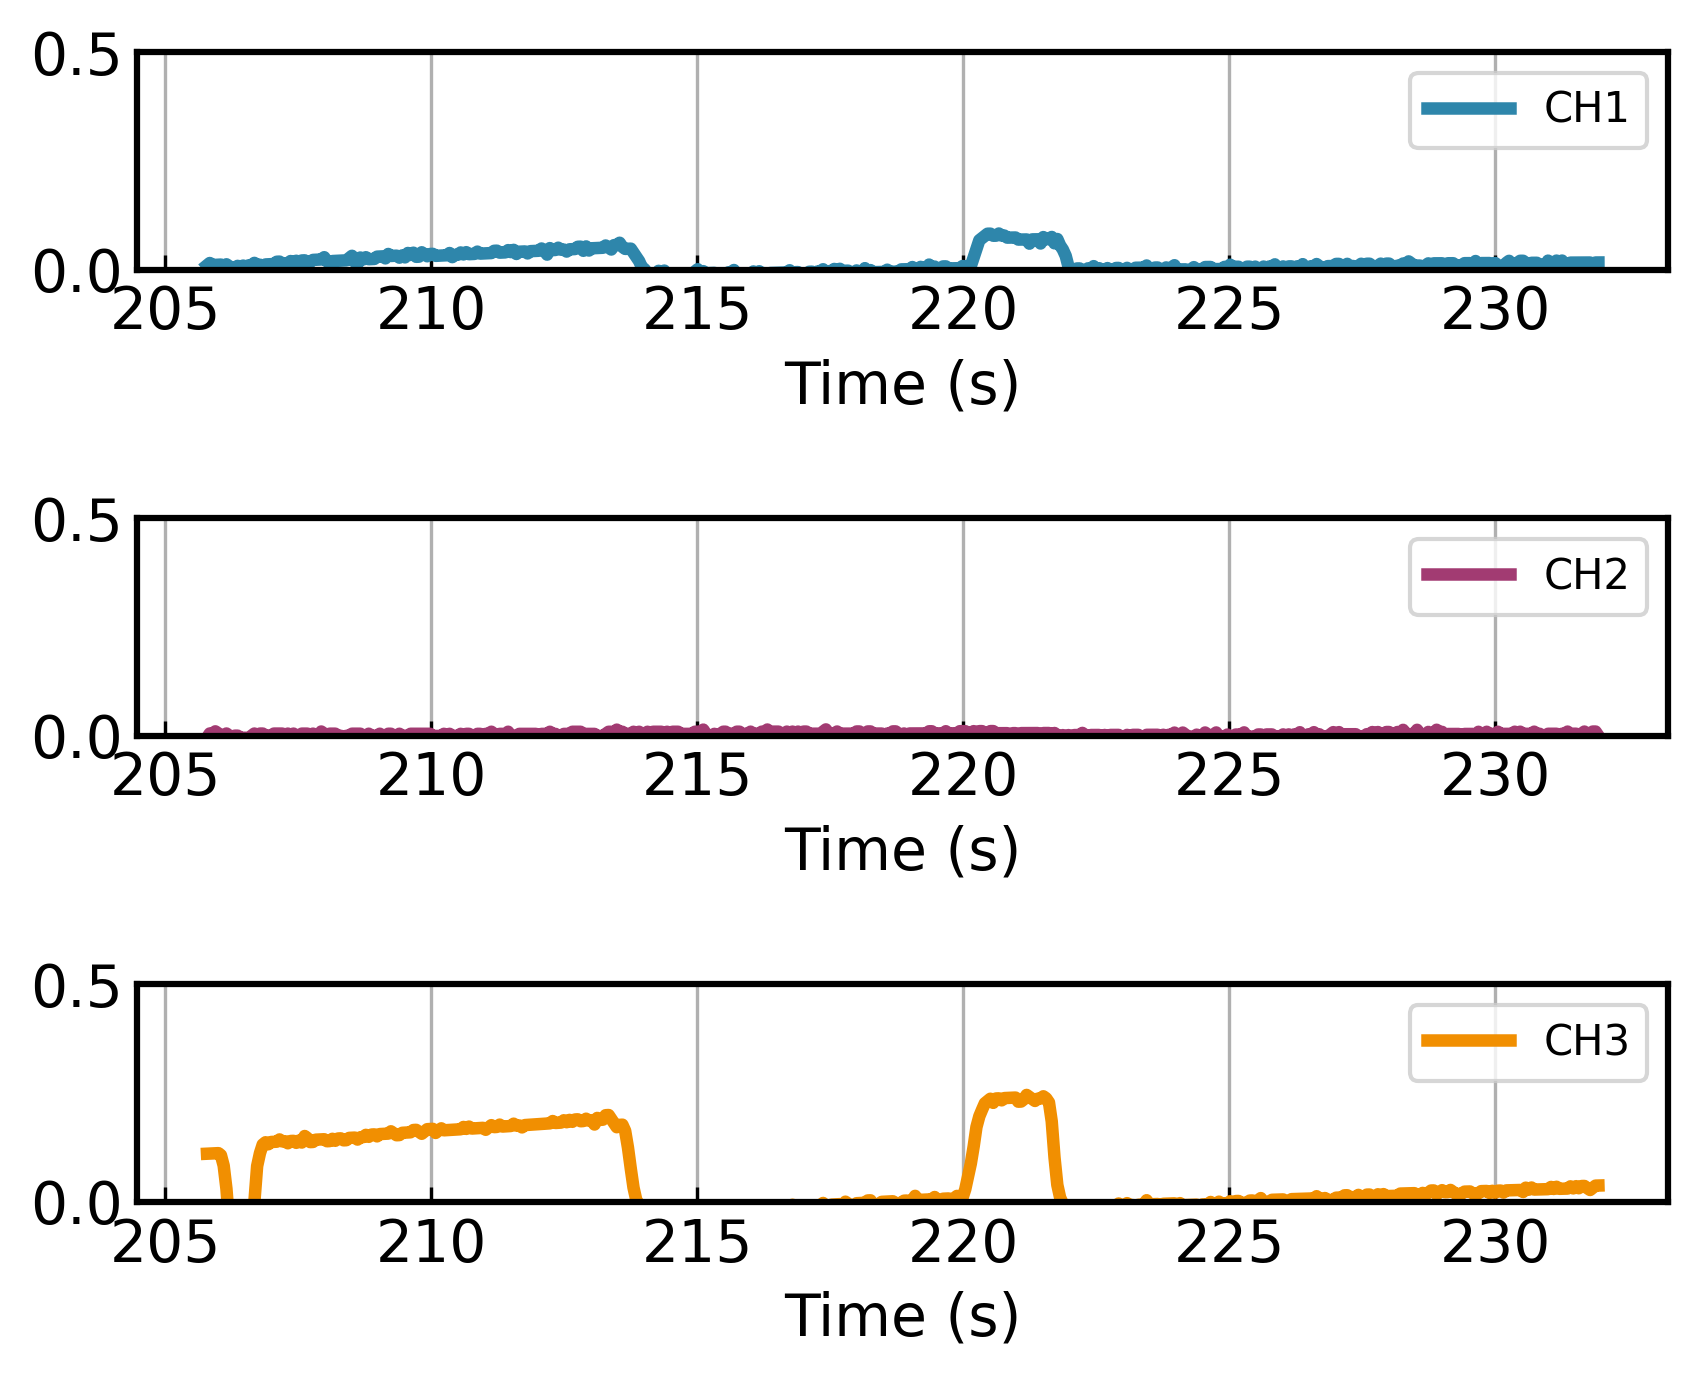

In [9]:
data_dir = "/Volumes/T7_Shield/Hydrogel_sensor/20250307_data_lh_acce/lh0307_success"
visualize_channel_data(data_dir)